In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [9]:
# ---------------------
# Load the dataset
# ---------------------
data = pd.read_csv('./ecommerce_customer_behavior.csv')
print("Dataset shape:", data.shape)
print("Dataset preview:")
print(data.head())

Dataset shape: (350, 11)
Dataset preview:
   Customer ID  Gender  Age           City Membership Type  Total Spend  \
0          101  Female   29       New York            Gold      1120.20   
1          102    Male   34    Los Angeles          Silver       780.50   
2          103  Female   43        Chicago          Bronze       510.75   
3          104    Male   30  San Francisco            Gold      1480.30   
4          105    Male   27          Miami          Silver       720.40   

   Items Purchased  Average Rating  Discount Applied  \
0               14             4.6              True   
1               11             4.1             False   
2                9             3.4              True   
3               19             4.7             False   
4               13             4.0              True   

   Days Since Last Purchase Satisfaction Level  
0                        25          Satisfied  
1                        18            Neutral  
2                      

In [10]:
# ---------------------
# Data Exploration
# ---------------------
print("\nMissing values per column:")
print(data.isnull().sum())
print("\nData types:")
print(data.dtypes)

# There are 2 missing values in 'Satisfaction Level'. Drop these rows.
data = data.dropna(subset=['Satisfaction Level'])


Missing values per column:
Customer ID                 0
Gender                      0
Age                         0
City                        0
Membership Type             0
Total Spend                 0
Items Purchased             0
Average Rating              0
Discount Applied            0
Days Since Last Purchase    0
Satisfaction Level          2
dtype: int64

Data types:
Customer ID                   int64
Gender                       object
Age                           int64
City                         object
Membership Type              object
Total Spend                 float64
Items Purchased               int64
Average Rating              float64
Discount Applied               bool
Days Since Last Purchase      int64
Satisfaction Level           object
dtype: object


In [11]:
# ---------------------
# Create Target Variable
# ---------------------
# We'll define a binary target: 'Satisfied' if Satisfaction Level is "Satisfied", else "Not Satisfied"
data['Satisfied'] = data['Satisfaction Level'].apply(lambda x: 1 if x.strip().lower() == "satisfied" else 0)
print("\nTarget variable distribution:")
print(data['Satisfied'].value_counts())


Target variable distribution:
Satisfied
0    223
1    125
Name: count, dtype: int64


In [12]:
# ---------------------
# Data Preprocessing
# ---------------------
# We will drop columns that are not needed for modeling: "Customer ID" and "Satisfaction Level"
data_model = data.drop(columns=["Customer ID", "Satisfaction Level"])

# Define categorical features and convert them using LabelEncoder
categorical_features = ['Gender', 'City', 'Membership Type']
le = LabelEncoder()
for col in categorical_features:
    data_model[col] = le.fit_transform(data_model[col])

# Display updated dataframe head
print("\nData after encoding categorical variables:")
print(data_model.head())

# Define feature set (X) and target (y)
# Features: Age, Total Spend, Items Purchased, Average Rating, Discount Applied (bool as 0/1),
# Days Since Last Purchase, plus encoded categorical features.
feature_columns = ['Age', 'Total Spend', 'Items Purchased', 'Average Rating',
                   'Discount Applied', 'Days Since Last Purchase'] + categorical_features

X = data_model[feature_columns]
y = data_model['Satisfied']

# Ensure boolean column is converted to numeric (True->1, False->0)
X['Discount Applied'] = X['Discount Applied'].astype(int)

# Feature Scaling for numeric features
numeric_features = ['Age', 'Total Spend', 'Items Purchased', 'Average Rating', 'Days Since Last Purchase']
scaler = StandardScaler()
X[numeric_features] = scaler.fit_transform(X[numeric_features])


Data after encoding categorical variables:
   Gender  Age  City  Membership Type  Total Spend  Items Purchased  \
0       0   29     4                1      1120.20               14   
1       1   34     2                2       780.50               11   
2       0   43     0                0       510.75                9   
3       1   30     5                1      1480.30               19   
4       1   27     3                2       720.40               13   

   Average Rating  Discount Applied  Days Since Last Purchase  Satisfied  
0             4.6              True                        25          1  
1             4.1             False                        18          0  
2             3.4              True                        42          0  
3             4.7             False                        12          1  
4             4.0              True                        55          0  


<ipython-input-12-2cc9d2071978>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Discount Applied'] = X['Discount Applied'].astype(int)
<ipython-input-12-2cc9d2071978>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numeric_features] = scaler.fit_transform(X[numeric_features])


In [13]:
# ---------------------
# Split Data into Train and Test Sets
# ---------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
print("\nTraining set size:", X_train.shape)
print("Test set size:", X_test.shape)



Training set size: (243, 9)
Test set size: (105, 9)


In [14]:
# ---------------------
# Model Building: Logistic Regression with Cross-Validation
# ---------------------
model = LogisticRegression(max_iter=1000, solver='liblinear')
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
print(f"\nCross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean()*100:.2f}%")

# Fit the model on the training data
model.fit(X_train, y_train)



Cross-Validation Accuracy Scores: [0.95918367 0.95918367 0.93877551 0.97916667 1.        ]
Mean CV Accuracy: 96.73%


LogisticRegression(max_iter=1000, solver='liblinear')


Test Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        67
           1       1.00      1.00      1.00        38

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105



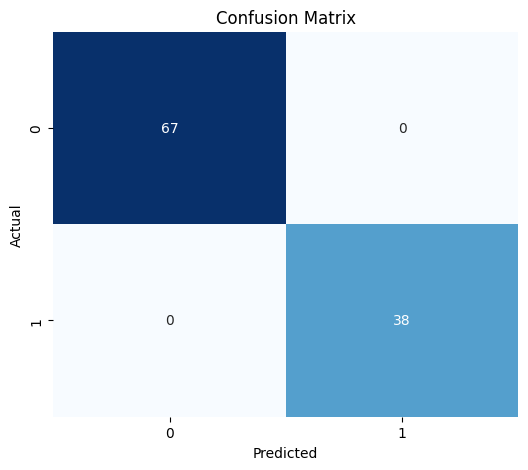

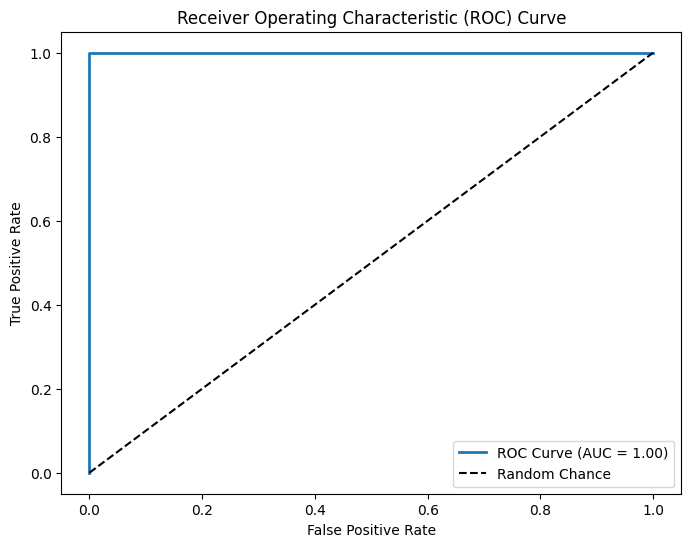

In [15]:
# ---------------------
# Model Evaluation
# ---------------------
# Predict on test set
y_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve and AUC
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", lw=2)
plt.plot([0, 1], [0, 1], "k--", label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


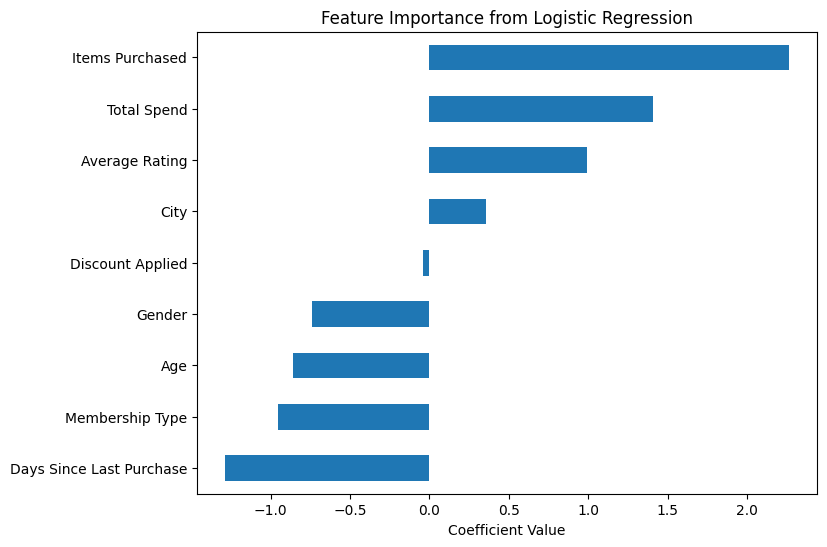


Model Coefficients:
Days Since Last Purchase   -1.285178
Membership Type            -0.951622
Age                        -0.860054
Gender                     -0.739572
Discount Applied           -0.039010
City                        0.358944
Average Rating              0.991662
Total Spend                 1.410739
Items Purchased             2.263914
dtype: float64


In [16]:
# ---------------------
# Feature Importance (Logistic Regression Coefficients)
# ---------------------
coefficients = pd.Series(model.coef_[0], index=feature_columns).sort_values()
plt.figure(figsize=(8, 6))
coefficients.plot(kind="barh")
plt.xlabel("Coefficient Value")
plt.title("Feature Importance from Logistic Regression")
plt.show()

# Output model coefficients for interpretation
print("\nModel Coefficients:")
print(coefficients)
